In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split


**Count files in classes**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Normal has 637 files.
Pneumonia has 574 files.


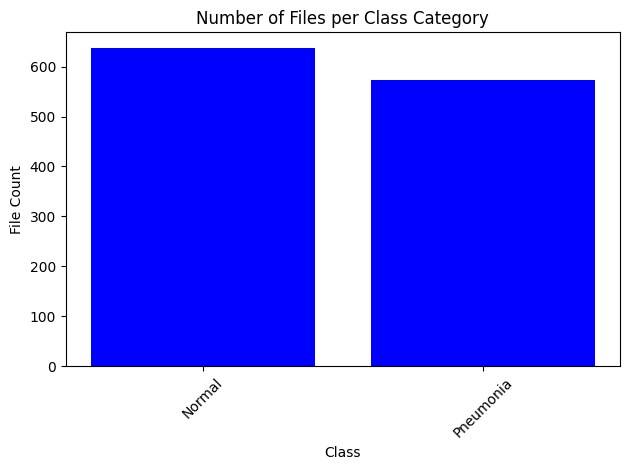

In [ ]:
import os
import matplotlib.pyplot as plt

# Set paths
root_dir = '/content/drive/MyDrive/dataset'  # Path to main data folder

# Define class categories
classes = ['Normal', 'Pneumonia']

# List to store file counts
file_counts = []

# Iterate through each class category
for class_name in classes:
    class_folder = os.path.join(root_dir, class_name)
    file_count = len(os.listdir(class_folder))
    file_counts.append(file_count)
    print(f"{class_name} has {file_count} files.")

# Create a bar graph to visualize file counts
plt.bar(classes, file_counts, color='blue')
plt.xlabel('Class')
plt.ylabel('File Count')
plt.title('Number of Files per Class Category')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the graph
plt.show()


**Features Extraction of Normal and Pneumonia Classes Combinedly saving as Single CSV FIle**

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd

# Set paths
root_dir = '/content/drive/MyDrive/dataset'  # Path to the directory containing both Pneumonia and Normal folders
output_dir = '/content/drive/MyDrive/Features/Features_Output'  # Directory to save CSV file

# Define classes
classes = ['Pneumonia', 'Normal']
num_mfccs = 20  # Number of MFCC coefficients
num_chroma = 20  # Number of chroma coefficients
clip_length = 4  # Clip duration in seconds

feature_data = []

# Define function to extract features and adjust clip length
def extract_features(file_path, clip_length):
    try:
        audio, sr = librosa.load(file_path, sr=None, duration=clip_length)
        if len(audio) < sr * clip_length:
            padding = np.zeros(sr * clip_length - len(audio))
            audio = np.concatenate((audio, padding))
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfccs)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_chroma=num_chroma)
        return mfccs, chroma
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

# Iterate through each class
for class_name in classes:
    class_folder = os.path.join(root_dir, class_name)

    for file_name in os.listdir(class_folder):
        file_path = os.path.join(class_folder, file_name)
        mfccs, chroma = extract_features(file_path, clip_length)

        if mfccs is not None and chroma is not None:
            label = class_name  # Use class name as label
            feature_data.append((mfccs, chroma, label))

# Filter out entries with None values
feature_data = [data for data in feature_data if all(item is not None for item in data[:2])]

# Calculate the minimum number of frames among all features
min_frames = min(data[0].shape[1] for data in feature_data)

# Calculate the mean of each feature across frames
mean_features = []
for data in feature_data:
    mfcc_mean = np.mean(data[0][:, :min_frames], axis=1)
    chroma_mean = np.mean(data[1][:, :min_frames], axis=1)
    mean_features.append(np.concatenate((mfcc_mean, chroma_mean)))

mean_features = np.array(mean_features)

# Add class labels as a separate column
class_labels = np.array([data[2] for data in feature_data])

# Create column labels
columns = []
for i in range(num_mfccs):
    columns.append(f'mean_mfcc_{i}')
for i in range(num_chroma):
    columns.append(f'mean_chroma_{i}')
columns.append('label')

# Create a DataFrame with mean features and class labels
df = pd.DataFrame(data=np.hstack((mean_features, class_labels.reshape(-1, 1))),
                  columns=columns)

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the DataFrame to CSV
output_file = os.path.join(output_dir, 'Pneumonia_and_Normal_dataset.csv')
df.to_csv(output_file, index=False)
print("Combined Features with Labels and Chroma shape:", df.shape)


Combined Features with Labels and Chroma shape: (1211, 41)


**Reading and Printing CSV**

In [ ]:
 df=pd.read_csv("/content/drive/MyDrive/Features/Features_Output/Pneumonia_and_Normal_dataset.csv")
print(df)



      mean_mfcc_0  mean_mfcc_1  mean_mfcc_2  mean_mfcc_3  mean_mfcc_4  \
0     -261.129425    95.199081   -50.478783    15.721434   -38.228519   
1     -342.552685    70.061839   -47.863924    10.097779   -25.888996   
2     -369.456658   136.831240   -15.335107    -3.933416   -11.415353   
3     -476.868496    45.862944   -17.587941     1.821178   -16.253449   
4     -446.717885    57.025697   -34.181515     1.634024   -16.761943   
...           ...          ...          ...          ...          ...   
1206  -326.594849    76.734100   -89.351532   -12.884353   -39.061886   
1207  -405.174988    29.282860  -104.875145    10.175251   -58.797485   
1208  -575.676630    23.030070    -1.286684    -3.928288    -1.617563   
1209  -625.181382    36.558960   -12.659304     0.386305    -4.823874   
1210  -775.359273    24.102344   -18.366487     6.823109   -10.940032   

      mean_mfcc_5  mean_mfcc_6  mean_mfcc_7  mean_mfcc_8  mean_mfcc_9  ...  \
0        4.253804   -27.552452     3.452350  

**Label Encoding CSV**

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the dataset from a CSV file
csv_file_path = '/content/drive/MyDrive/Features/Features_Output/Pneumonia_and_Normal_dataset.csv'
df = pd.read_csv(csv_file_path)

# Explicitly convert the "label" column to strings
df['label'] = df['label'].astype(str)

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit the LabelEncoder to your class labels and transform them
df['label'] = label_encoder.fit_transform(df['label'])

# Save the DataFrame with encoded labels to a specific folder in your Google Drive
output_csv_file = '/content/drive/MyDrive/Features/Features_Output/encoded_dataset.csv'
df.to_csv(output_csv_file, index=False)

print("Label encoding completed and saved to", output_csv_file)


Label encoding completed and saved to /content/drive/MyDrive/Features/Features_Output/encoded_dataset.csv


**Reading and Printing Lable Encoded CSV**

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Features/Features_Output/encoded_dataset.csv")
print(df)

      mean_mfcc_0  mean_mfcc_1  mean_mfcc_2  mean_mfcc_3  mean_mfcc_4  \
0     -261.129425    95.199081   -50.478783    15.721434   -38.228519   
1     -342.552685    70.061839   -47.863924    10.097779   -25.888996   
2     -369.456658   136.831240   -15.335107    -3.933416   -11.415353   
3     -476.868496    45.862944   -17.587941     1.821178   -16.253449   
4     -446.717885    57.025697   -34.181515     1.634024   -16.761943   
...           ...          ...          ...          ...          ...   
1206  -326.594849    76.734100   -89.351532   -12.884353   -39.061886   
1207  -405.174988    29.282860  -104.875145    10.175251   -58.797485   
1208  -575.676630    23.030070    -1.286684    -3.928288    -1.617563   
1209  -625.181382    36.558960   -12.659304     0.386305    -4.823874   
1210  -775.359273    24.102344   -18.366487     6.823109   -10.940032   

      mean_mfcc_5  mean_mfcc_6  mean_mfcc_7  mean_mfcc_8  mean_mfcc_9  ...  \
0        4.253804   -27.552452     3.452350  

**Plotting Distribution of Encoded Labels**

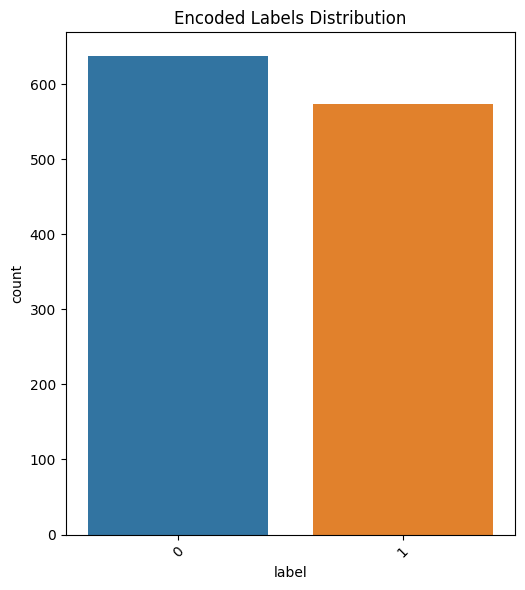

Unique encoded labels: [1 0]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the full path to the encoded CSV file
encoded_file = '/content/drive/MyDrive/Features/Features_Output/encoded_dataset.csv'

# Load the encoded CSV file
df = pd.read_csv(encoded_file)

# Assuming that the encoded labels are in a specific column (e.g., 'label')
encoded_labels_column = 'label'  # Replace with the correct column name

# Visualize the label encoding results
plt.figure(figsize=(10, 6))

# Plot the distribution of the encoded labels
plt.subplot(1, 2, 1)
sns.countplot(data=df, x=encoded_labels_column)
plt.title('Encoded Labels Distribution')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# Print the unique encoded labels
print("Unique encoded labels:", df[encoded_labels_column].unique())


**1D CNN Model Implementation, Training and Evaluation**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Features/Features_Output/encoded_dataset.csv')  # Replace 'your_dataset.csv' with your actual dataset file.

# Separate features and labels
X = data.iloc[:, :-1].values
y = data['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data to fit the 2D CNN input shape
X_train = X_train.reshape(X_train.shape[0], 20, 2)
X_test = X_test.reshape(X_test.shape[0], 20, 2)

# Convert labels to one-hot encoded vectors
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

# Define the CNN model with 2D convolution layers
model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(20, 2)))
model.add(layers.MaxPooling1D(1))  # Adjusted pooling size
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.MaxPooling1D(1))  # Adjusted pooling size
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))  # 2 classes: Pneumonia and Normal


# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history=model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')


Epoch 1/10
31/31 [==============================] - 2s 15ms/step - loss: 0.9399 - accuracy: 0.5145 - val_loss: 0.6652 - val_accuracy: 0.5720
Epoch 2/10
31/31 [==============================] - 0s 8ms/step - loss: 0.6396 - accuracy: 0.6384 - val_loss: 0.6104 - val_accuracy: 0.6996
Epoch 3/10
31/31 [==============================] - 0s 8ms/step - loss: 0.5811 - accuracy: 0.7138 - val_loss: 0.5640 - val_accuracy: 0.7243
Epoch 4/10
31/31 [==============================] - 0s 9ms/step - loss: 0.5330 - accuracy: 0.7459 - val_loss: 0.5330 - val_accuracy: 0.7531
Epoch 5/10
31/31 [==============================] - 0s 8ms/step - loss: 0.4678 - accuracy: 0.7862 - val_loss: 0.5090 - val_accuracy: 0.7284
Epoch 6/10
31/31 [==============================] - 0s 8ms/step - loss: 0.4185 - accuracy: 0.8068 - val_loss: 0.4469 - val_accuracy: 0.8025
Epoch 7/10
31/31 [==============================] - 0s 10ms/step - loss: 0.3824 - accuracy: 0.8316 - val_loss: 0.3810 - val_accuracy: 0.8724
Epoch 8/10
31/31 [

**Saving the Model**

In [ ]:
# Save the trained model to a file
model.save('/content/drive/MyDrive/Trained_Models/MY_Model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Printing the Model Layers and Input Shape**

In [ ]:
model.summary()
input_shape = model.layers[0].input_shape
print("Input Shape:", input_shape)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_33 (Conv1D)          (None, 18, 32)            224       
                                                                 
 max_pooling1d_22 (MaxPooli  (None, 18, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_34 (Conv1D)          (None, 16, 64)            6208      
                                                                 
 max_pooling1d_23 (MaxPooli  (None, 16, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_35 (Conv1D)          (None, 14, 64)            12352     
                                                                 
 flatten_12 (Flatten)        (None, 896)             

**Acuuracy curves and Loss Curves for 1DCNN**

8/8 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       122
           1       0.94      0.88      0.91       121

    accuracy                           0.91       243
   macro avg       0.92      0.91      0.91       243
weighted avg       0.91      0.91      0.91       243



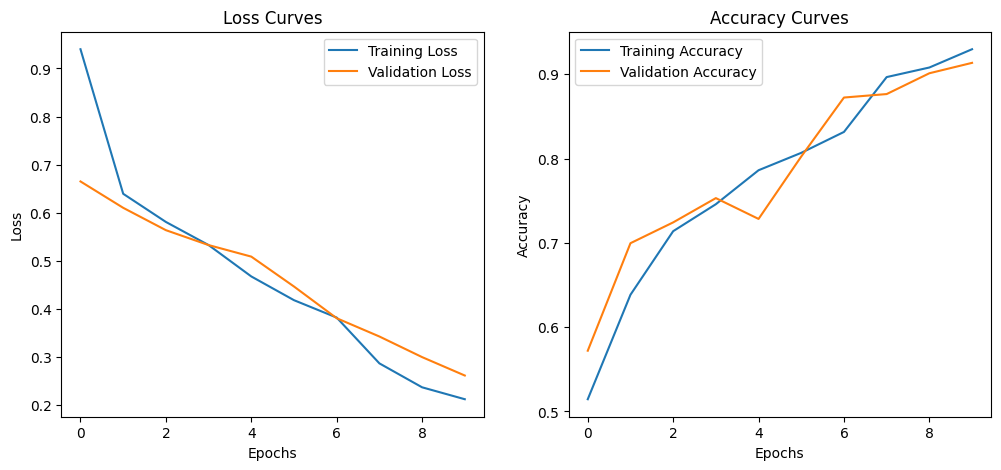

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
# Predict class labels on the test set
X_test_reshaped = X_test.reshape(X_test.shape[0], 20, 2)
# Convert one-hot encoded y_test back to class labels
y_true = np.argmax(y_test.to_numpy(), axis=1)
y_pred = np.argmax(model.predict(X_test_reshaped), axis=1)

# Print classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

# Plot training history (optional)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')

plt.show()

**Confusion Matrix for 1DCNN**

8/8 [==============================] - 0s 4ms/step - loss: 0.2620 - accuracy: 0.9136
Test accuracy: 0.9135802388191223
8/8 [==============================] - 0s 4ms/step


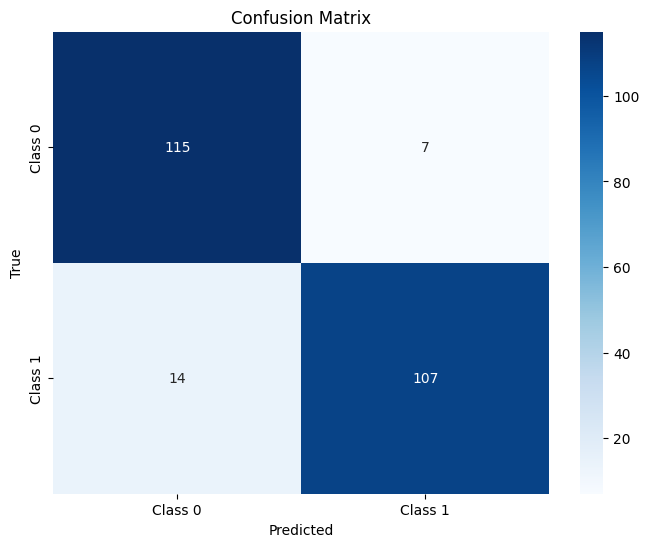

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ... (your existing code)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')

# Predict classes on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(np.array(y_test), axis=1)

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**Printing and Saving Model Architecture as JPG 1DCNN**

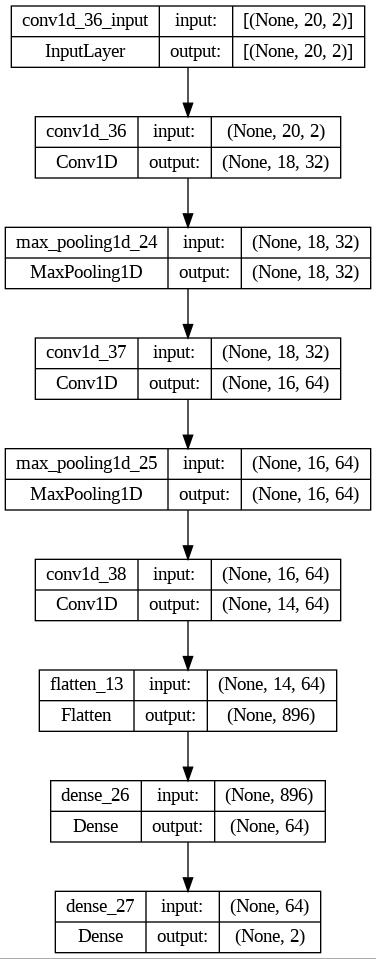

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Features/Features_Output/encoded_dataset.csv')  # Replace with your actual dataset file.

# Separate features and labels
X = data.iloc[:, :-1].values
y = data['label'].values

# Reshape the data to fit
X = X.reshape(X.shape[0], 20, 2)

# Convert labels to one-hot encoded vectors
y = pd.get_dummies(y)

# Define the CNN model with 2D convolution layers
model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(20, 2)))
model.add(layers.MaxPooling1D(1))  # Adjusted pooling size
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.MaxPooling1D(1))  # Adjusted pooling size
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))  # 2 classes: Pneumonia and Normal

# Specify the folder to save the model architecture plot
save_folder = '/content/drive/MyDrive/Model_Architecture/1DCNN/1DCNN'  # Replace with your desired folder path

# Plot the model architecture and save it as a .jpg file
plot_model(model, to_file=save_folder + 'model_architecture.jpg', show_shapes=True)


**Testing the 1DCNN Model**

In [65]:
import tensorflow as tf

# Load the trained model
model_path = '/content/drive/MyDrive/Trained_Models/MY_Model.h5'
loaded_model = tf.keras.models.load_model(model_path)
import librosa
import numpy as np

# Constants for feature extraction
SAMPLE_RATE = 22050
DURATION = 4
MFCC_FEATURES = 2  # Change this to match the model's input shape

# Function to extract MFCC features from an audio clip
def extract_features(file_path, target_length):
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    mfccs = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=MFCC_FEATURES)

    # Pad or truncate to the target length
    if mfccs.shape[1] < target_length:
        mfccs = np.pad(mfccs, ((0, 0), (0, target_length - mfccs.shape[1])), mode='constant')
    elif mfccs.shape[1] > target_length:
        mfccs = mfccs[:, :target_length]

    return mfccs

# Path to your audio clip
audio_clip_path = '/content/drive/MyDrive/CustomDataTesting/Recording (2).wav'

# Extract MFCC features from the audio clip
target_length = 20  # The target length for your model's input shape
audio_features = extract_features(audio_clip_path, target_length)

# Reshape the audio features to match the model's input shape
audio_features = audio_features.reshape(1, 20, MFCC_FEATURES)  # Ensure MFCC_FEATURES is set correctly

# Make predictions
predictions = loaded_model.predict(audio_features)

# Assuming binary classification (Pneumonia and Normal)
if predictions[0][0] > predictions[0][1]:
    predicted_class = 'Normal'
else:
    predicted_class = 'Pneumonia'

print(f'Predicted Class: {predicted_class}')


1/1 [==============================] - 0s 120ms/step
Predicted Class: Normal


**2D CNN Implementation, Loss Curves and Accuracy Curves**

Training the 2D CNN model...
Epoch 1/20
28/28 [==============================] - 2s 20ms/step - loss: 4.8824 - accuracy: 0.5029 - val_loss: 2.2671 - val_accuracy: 0.5052
Epoch 2/20
28/28 [==============================] - 0s 8ms/step - loss: 1.4989 - accuracy: 0.5235 - val_loss: 0.8923 - val_accuracy: 0.5464
Epoch 3/20
28/28 [==============================] - 0s 10ms/step - loss: 0.7999 - accuracy: 0.5499 - val_loss: 0.6514 - val_accuracy: 0.6186
Epoch 4/20
28/28 [==============================] - 0s 8ms/step - loss: 0.7037 - accuracy: 0.5293 - val_loss: 0.6644 - val_accuracy: 0.5979
Epoch 5/20
28/28 [==============================] - 0s 8ms/step - loss: 0.6846 - accuracy: 0.5465 - val_loss: 0.6668 - val_accuracy: 0.5670
Epoch 6/20
28/28 [==============================] - 0s 8ms/step - loss: 0.6718 - accuracy: 0.5947 - val_loss: 0.6664 - val_accuracy: 0.5773
Epoch 7/20
28/28 [==============================] - 0s 9ms/step - loss: 0.6692 - accuracy: 0.5591 - val_loss: 0.6643 - val_accura

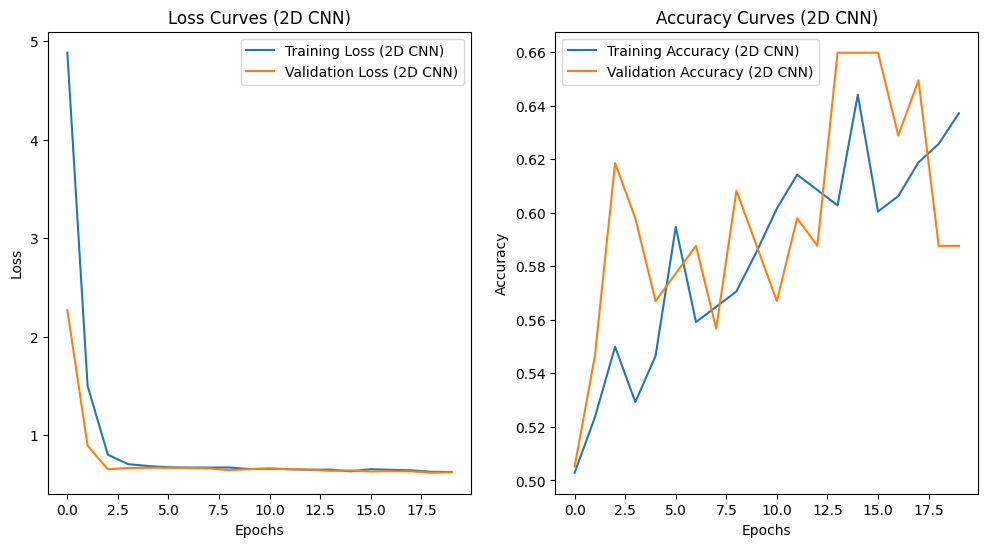

In [64]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load the CSV file with features
csv_file = '/content/drive/MyDrive/Features/Features_Output/encoded_dataset.csv'  # Replace with your CSV file path
data = pd.read_csv(csv_file)

# Split data into features (X) and labels (y)
X = data.iloc[:, :-1].values  # Exclude the last column ('label')
y = data['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the features for the 2D CNN input format
num_rows, num_columns =10, 4  # Adjust as needed based on your feature dimensions
X_train_reshaped = X_train.reshape(X_train.shape[0], num_rows, num_columns, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], num_rows, num_columns, 1)

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Build the 2D CNN model
model_cnn2d = Sequential()
model_cnn2d.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(num_rows, num_columns, 1)))
model_cnn2d.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2d.add(Flatten())
model_cnn2d.add(Dense(128, activation='relu'))
model_cnn2d.add(Dropout(0.5))
model_cnn2d.add(Dense(len(np.unique(y)), activation='softmax'))

# Compile the model with the desired optimizer and loss function
model_cnn2d.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the 2D CNN model and capture the training history
print("Training the 2D CNN model...")
history_cnn2d = model_cnn2d.fit(X_train_reshaped, y_train_one_hot, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate the 2D CNN model on the test set
print("\nEvaluating the 2D CNN model on the test set...")
loss_cnn2d, accuracy_cnn2d = model_cnn2d.evaluate(X_test_reshaped, y_test_one_hot)
print(f"Test Loss (2D CNN): {loss_cnn2d:.4f}")
print(f"Test Accuracy (2D CNN): {accuracy_cnn2d:.4f}")

# Predict class labels on the test set using the 2D CNN model
y_pred_cnn2d = np.argmax(model_cnn2d.predict(X_test_reshaped), axis=1)

# Print classification report for the 2D CNN model
class_report_cnn2d = classification_report(y_test, y_pred_cnn2d)
print("Classification Report (2D CNN):")
print(class_report_cnn2d)

# Plot training history for the 2D CNN model (optional)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_cnn2d.history['loss'], label='Training Loss (2D CNN)')
plt.plot(history_cnn2d.history['val_loss'], label='Validation Loss (2D CNN)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves (2D CNN)')

plt.subplot(1, 2, 2)
plt.plot(history_cnn2d.history['accuracy'], label='Training Accuracy (2D CNN)')
plt.plot(history_cnn2d.history['val_accuracy'], label='Validation Accuracy (2D CNN)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves (2D CNN)')

plt.show()


In [ ]:
# Save the trained model to a file
model_cnn2d.save('/content/drive/MyDrive/Trained_Models/2DCNN/Model2D.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 8, 2, 64)          640       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 1, 64)          0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 256)               0         
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 2)                 258       
                                                     

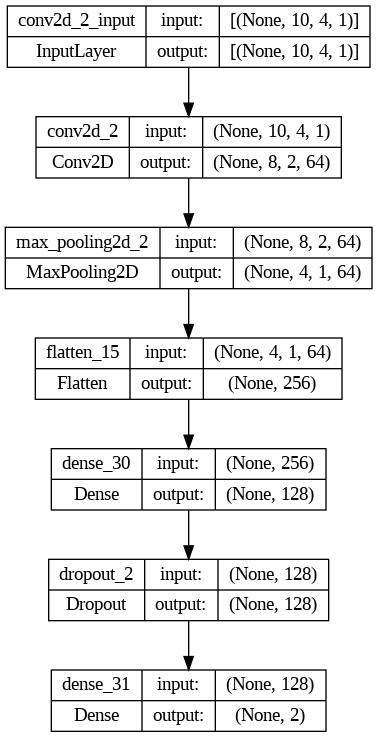

In [ ]:
from IPython.display import Image

model_cnn2d.summary()

# Save the model architecture as a jpg file
model_architecture_path = '/content/drive/MyDrive/Model_Architecture/2DCNN/2DCNN_model_architecture.jpg'  # Replace with your desired file path
plot_model(model_cnn2d, to_file=model_architecture_path, show_shapes=True, show_layer_names=True)

print(f"2D CNN Model architecture saved to {model_architecture_path}")

# Display the saved architecture image
Image(model_architecture_path)

**Confusion matrix for 2DCNN**

8/8 [==============================] - 0s 2ms/step
Confusion Matrix:
[[116   6]
 [ 35  86]]


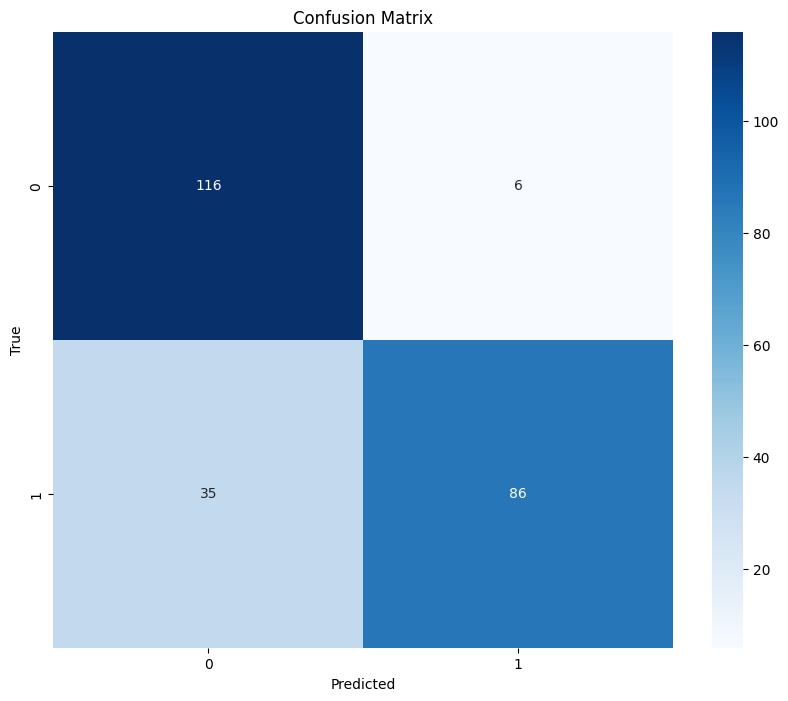

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



# Predict class labels on the test set using the 2D CNN model
y_pred_cnn2d = np.argmax(model_cnn2d.predict(X_test_reshaped), axis=1)

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_cnn2d)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Plot confusion matrix as a heatmap (optional)
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import tensorflow as tf

# Load the trained model
model_path = '/content/drive/MyDrive/Trained_Models/2DCNN/Model2D.h5'
loaded_model = tf.keras.models.load_model(model_path)
import librosa
import numpy as np

# Constants for feature extraction
SAMPLE_RATE = 22050
DURATION = 4
MFCC_FEATURES = 2  # Change this to match the model's input shape

# Function to extract MFCC features from an audio clip
def extract_features(file_path, target_length):
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    mfccs = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=MFCC_FEATURES)

    # Pad or truncate to the target length
    if mfccs.shape[1] < target_length:
        mfccs = np.pad(mfccs, ((0, 0), (0, target_length - mfccs.shape[1])), mode='constant')
    elif mfccs.shape[1] > target_length:
        mfccs = mfccs[:, :target_length]

    return mfccs

# Path to your audio clip
audio_clip_path = '/content/drive/MyDrive/CustomDataTesting/Recording.wav'

# Extract MFCC features from the audio clip
target_length = 20  # The target length for your model's input shape
audio_features = extract_features(audio_clip_path, target_length)

# Reshape the audio features to match the model's input shape
# Reshape the audio features to match the model's input shape
audio_features = audio_features.reshape(1, 10, 4, 1)  # Ensure the shape matches (None, 10, 4, 1)

# Make predictions
predictions = loaded_model.predict(audio_features)

# Assuming binary classification (Pneumonia and Normal)
if predictions[0][0] > predictions[0][1]:
    predicted_class = 'Normal'
else:
    predicted_class = 'Pneumonia'

print(f'Predicted Class: {predicted_class}')


1/1 [==============================] - 0s 99ms/step
Predicted Class: Normal
